## Setup and Settings

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-lightning
    !pip install captum
    !pip install timm
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/polar-lows-detection-forecasting-deep-learning/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s eta 0:00:00
Mounted at /content/drive
/content/drive/MyDrive/polar-lows-detection-forecasting-deep-learning


In [2]:
import os
import cv2

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (
    DataLoader,
    Subset,
    WeightedRandomSampler,
    random_split
)
from torchvision import datasets, transforms
import pytorch_lightning as pl
from PIL import Image
from tqdm import tqdm

from models import (
    ConvModel,
    XceptionModel
)
from model_container import ModelContainer

In [3]:
import warnings

warnings.filterwarnings('ignore', message='.*DataLoader will create.*') # Suppressed the warning related to the creation of DataLoader using a high number of num_workers

In [4]:
# SETTINGS

num_workers_for_data_loaders = 8 if torch.cuda.is_available() else 6 # 8 should be optimal if GPU is available. 6 should be optimal for CPU.

image_resolution = (299, 299) # Image resolution to use for training
batch_size = 32

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Auxiliary Functions

In [6]:
def show_image(image, title=""):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
def get_targets_and_classes(dataset):
    if isinstance(dataset, Subset):
        original_dataset = dataset.dataset
        subset_indices = dataset.indices
        targets = [original_dataset.targets[i] for i in subset_indices]
        classes = original_dataset.classes
        class_to_idx = dataset.dataset.class_to_idx
    else:
        targets = dataset.targets
        classes = dataset.classes
        class_to_idx = dataset.class_to_idx
    return targets, classes, class_to_idx

In [8]:
def print_dataset_stats(dataset, dataset_name=""):
    # Retrive targes, class information, and class-to-index mapping
    targets, classes, class_to_idx = get_targets_and_classes(dataset)

    # Count the occurrences of each class in the dataset
    dataset_counts = Counter(targets)

    # Get class indices for 'pos' and 'neg'
    pos_idx = class_to_idx['pos']
    neg_idx = class_to_idx['neg']

    # Get the number of positive and negative samples
    pos_count = dataset_counts[pos_idx]
    neg_count = dataset_counts[neg_idx]
    total_count = len(targets)

    # Calculate the class ratio and percentages
    class_ratio = pos_count / neg_count if neg_count > 0 else float('inf')
    pos_percentage = (pos_count / total_count) * 100
    neg_percentage = (neg_count / total_count) * 100

    # Print dataset statistics
    print(f"'{dataset_name}' dataset:")
    print(f"\tNumber of samples: {total_count} (neg: {neg_count}, pos: {pos_count})")
    print(f"\tNumber of classes: {len(classes)}")
    print(f"\tClass names: {classes}")
    print(f"\tClass distribution ratio (pos:neg): {class_ratio:.2f}")
    print(f"\tClass percentages: {pos_percentage:.2f}% pos, {neg_percentage:.2f}% neg")
    print()

In [9]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating model'):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

## Load and Inspect Data

In [10]:
data_augmentation = transforms.Compose([
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), fill=0),  # Random Rotation, Translation, and Zoom
    transforms.RandomHorizontalFlip(),  # Random Horizontal Flip
    transforms.RandomVerticalFlip(),  # Random Vertical Flip
    transforms.Resize(image_resolution),  # Resize
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Rescaling / Normalizing
])

data_prep = transforms.Compose([
    transforms.Resize(image_resolution),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Rescaling / Normalizing
])

In [11]:
train_dir = 'data/train'
test_dir = 'data/test'

train_val_data = datasets.ImageFolder(train_dir, transform=data_augmentation)
test_data = datasets.ImageFolder(test_dir, transform=data_prep)

In [12]:
from collections import Counter

print_dataset_stats(train_val_data, "Train val")
print_dataset_stats(test_data, "Test")

'Train val' dataset:
	Number of samples: 1557 (neg: 1293, pos: 264)
	Number of classes: 2
	Class names: ['neg', 'pos']
	Class distribution ratio (pos:neg): 0.20
	Class percentages: 16.96% pos, 83.04% neg

'Test' dataset:
	Number of samples: 441 (neg: 371, pos: 70)
	Number of classes: 2
	Class names: ['neg', 'pos']
	Class distribution ratio (pos:neg): 0.19
	Class percentages: 15.87% pos, 84.13% neg



## Process Data

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

labels = train_val_data.targets

# Split the data into training and validation sets while preserving class proportions
for train_indices, val_indices in split.split(np.zeros(len(labels)), labels):
    print(f"Number of 'Train' indices: {len(train_indices)}")
    print(f"Number of 'Val' indices: {len(val_indices)}")

    train_data = Subset(train_val_data, train_indices)

    # For the validation data we reload the images so that we don't apply augmentation
    val_data = Subset(datasets.ImageFolder(train_dir, transform=data_prep), val_indices)

print_dataset_stats(train_data, "Train")
print_dataset_stats(val_data, "Val")


Number of 'Train' indices: 1245
Number of 'Val' indices: 312
'Train' dataset:
	Number of samples: 1245 (neg: 1034, pos: 211)
	Number of classes: 2
	Class names: ['neg', 'pos']
	Class distribution ratio (pos:neg): 0.20
	Class percentages: 16.95% pos, 83.05% neg

'Val' dataset:
	Number of samples: 312 (neg: 259, pos: 53)
	Number of classes: 2
	Class names: ['neg', 'pos']
	Class distribution ratio (pos:neg): 0.20
	Class percentages: 16.99% pos, 83.01% neg



In [14]:
train_data.dataset.transform

Compose(
    RandomAffine(degrees=[-45.0, 45.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [15]:
val_data.dataset.transform

Compose(
    Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [16]:
# Create data loader based on class balance (imbalance)

train_counts = Counter([train_val_data.targets[i] for i in train_indices])

class_weights_not_normalized = { cls: 1.0 / count for cls, count in train_counts.items() }
total_weights = sum(class_weights_not_normalized.values())
class_weights = { cls: weight / total_weights for cls, weight in class_weights_not_normalized.items() }
print("Class weights:")
print(class_weights)

sample_weights = [class_weights[train_val_data.targets[i]] for i in train_indices] # Assigns the corresponding weight to each sample in the train dataset

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader for training data using the sampler
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=num_workers_for_data_loaders)

# Create DataLoader for validation data without any sampler
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers_for_data_loaders)

Class weights:
{0: 0.16947791164658635, 1: 0.8305220883534137}


## Build Model

In [17]:
model = XceptionModel();

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

lit_model = ModelContainer(model, criterion, optimizer)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Number of channels in the last feature map: 2048


In [18]:
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    dirpath='checkpoints/',
    filename='best-checkpoint'
)

## Train Model

In [ ]:
trainer = pl.Trainer(
    max_epochs = 100,
    callbacks=[early_stopping_callback, checkpoint_callback],
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    check_val_every_n_epoch=1,
    precision=16 if torch.cuda.is_available() else 32 # Enables mixed precision
)

In [ ]:
trainer.fit(lit_model, train_loader, val_loader)

In [ ]:
# Plot training and validation loss over epochs
plt.plot(lit_model.train_losses, label='Train Loss')
plt.plot(lit_model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

## Load Model

In [19]:
# Load the best model
model = ModelContainer.load_from_checkpoint('checkpoints/xception-oct-13.ckpt', model=XceptionModel(), criterion=criterion, optimizer=optimizer)

Number of channels in the last feature map: 2048


## Model Evaluation

In [ ]:
val_preds, val_labels = evaluate_model(model, val_loader, device)

cm = confusion_matrix(val_labels, val_preds)
print("\n\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['neg', 'pos']))

f1 = f1_score(val_labels, val_preds, pos_label=1)
precision = precision_score(val_labels, val_preds, pos_label=1)
recall = recall_score(val_labels, val_preds, pos_label=1)

print(f"\nF1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Evaluating model: 100%|██████████| 10/10 [01:01<00:00,  6.13s/it]



Confusion Matrix:
[[258   1]
 [  3  50]]

Classification Report:
              precision    recall  f1-score   support

         neg       0.99      1.00      0.99       259
         pos       0.98      0.94      0.96        53

    accuracy                           0.99       312
   macro avg       0.98      0.97      0.98       312
weighted avg       0.99      0.99      0.99       312


F1 Score: 0.9615
Precision: 0.9804
Recall: 0.9434


Selected pointwise convolution layer: body.conv4.pointwise - Conv2d(1536, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


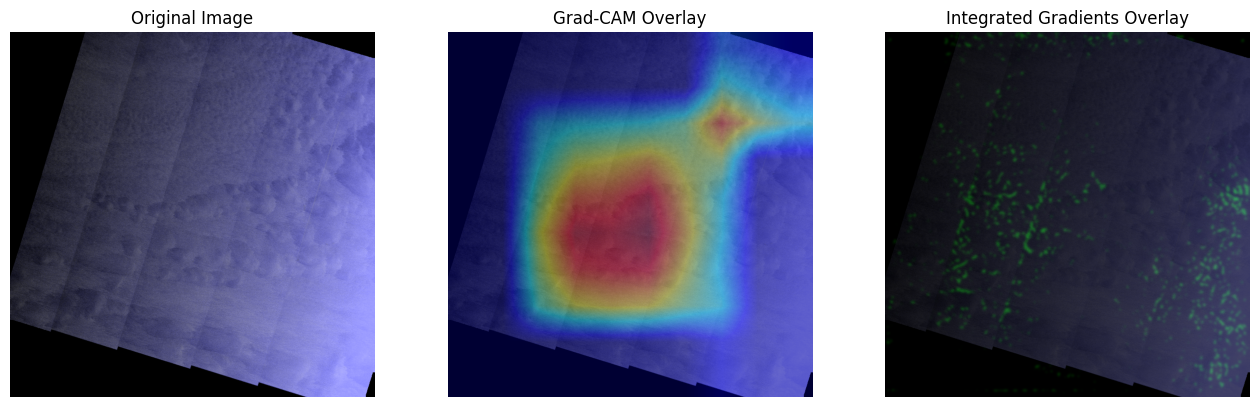

Image path: data/train/neg/71b62d_20200121T064241_20200121T064340_mos_rgb.png
Predicted: neg. Actual: neg


In [26]:
pos_images = os.listdir(os.path.join(train_dir, 'pos')) # Directory of 'pos' images
neg_images = os.listdir(os.path.join(train_dir, 'neg')) # Directory of 'neg' images

# Pick random image
category = random.choice(['pos', 'neg'])
chosen_image = random.choice(os.listdir(os.path.join(train_dir, category)))
image_path = os.path.join(train_dir, category, chosen_image)

# image_path = 'data/train/pos/ac2464_20161130T110210_20161130T110410_mos_rgb.png'

# Prepare image
original_image = Image.open(image_path).convert('RGB')
transformed_image = data_prep(original_image).unsqueeze(0)

# Create and overlay GradCAM heatmap
gradcam_heatmap = model.generate_gradcam_heatmap(transformed_image)
gradcam_overlayed = model.overlay_heatmap(original_image, gradcam_heatmap)

# Create and overlay Integrated Gradients heatmap
ig_heatmap, predicted_class = model.generate_integrated_gradients_heatmap(transformed_image)
ig_overlayed = model.overlay_green_heatmap(original_image, ig_heatmap, predicted_class)


# Display image with and without heatmap

plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 3, 1) # plt.subplot(num_rows, num_columns, index)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Image with Grad-CAM heatmap
plt.subplot(1, 3, 2)
plt.imshow(gradcam_overlayed)
plt.title('Grad-CAM Overlay')
plt.axis('off')

# Image with Integrated Gradients heatmap
plt.subplot(1, 3, 3)
plt.imshow(ig_overlayed)
plt.title('Integrated Gradients Overlay')
plt.axis('off')

plt.show()


# Print additional info

print(f'Image path: {image_path}') # Print image path

pred = torch.argmax(model(transformed_image.to(device)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: {category}')